## Problem 3 - Three Meter Dataset

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import torchvision
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#setting parameters
num_epochs = 40
batch_size = 100

In [3]:
#Reading csv dataset file
dataset = pd.read_csv('data.csv')
#getting a npy file
training_set = np.array(dataset, dtype = 'float32')
#saving a npy file
np.save('training_set.npy',training_set)

In [4]:
#loading the dataset
training_set = np.load('training_set.npy')

In [15]:
#Splitting the dataset into trainign and testing: The split is the default split of: 85% (training) - 15% (testing)
train, test = train_test_split(training_set, test_size = 0.15)
print(np.array(train).shape, np.array(test).shape)

(118320, 33) (20881, 33)


In [6]:
#Loads the images using loader class
#Abstract class representing a dataset
class ImgLoader(Dataset):
    def __init__(self, x, iscuda=False, transform=None):
        self.x = np.array(x)
        self.transform=transform
        self.cuda = iscuda
        
#supports indexing
    def __getitem__(self, index):
        x_val = self.x[index]
        return x_val

#returns size of dataset
    def __len__(self):
        return len(self.x)

In [7]:
#Checks for whether cuda is available so as to run on GPU or not
use_cuda = torch.cuda.is_available()
#img_loadertrain has the training images; on which transformations have been performed
img_loadertrain = ImgLoader(train, use_cuda, transform = None)
img_loadertest = ImgLoader(test, use_cuda, transform = None)
#datatrainloader has the training images; on which transformations have been performed
datatrainloader = DataLoader(img_loadertrain, batch_size=batch_size, shuffle=True)
#datatestloader has the training images; on which transformations have been performed
datatestloader = DataLoader(img_loadertest, batch_size=batch_size, shuffle=True)

In [8]:
print(img_loadertest[0])
print(img_loadertrain[0])

[4.7509 4.5877 4.5806 4.4718 4.4896 4.5586 4.4464 4.4881 4.6308 4.4433
 4.416  5.2101 5.1738 5.2229 5.2921 5.1908 5.021  5.5276 5.1263 5.3276
 4.5624 4.5075 4.6902 4.6521 4.6377 4.6332 4.4965 4.571  4.6604 4.6174
 4.6203 4.3283 4.6922]
[4.769  4.5664 4.5575 4.4865 4.492  4.5608 4.4491 4.4823 4.6232 4.4422
 4.4148 5.1949 5.1545 5.2006 5.2941 5.1873 5.0447 5.5405 5.1336 5.3107
 4.5775 4.5216 4.6699 4.6195 4.6073 4.6376 4.5247 4.5564 4.6631 4.6267
 4.609  4.32   4.7057]


In [9]:
#Network autoencoder is defined
class SAE(nn.Module):
    def __init__(self, ):
        # super function is used to use classes of parent class
        super(SAE,self).__init__()
        #encoding network
        self.fc1 = nn.Linear(33, 20)
        self.fc2 = nn.Linear(20, 10)
        #decoding network
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, 33)
    def forward(self, x):
        x = (self.fc1(x))
        x = (self.fc2(x))
        x = (self.fc3(x))
        x = (self.fc4(x))
        return x

In [10]:
#Making instance of the network
sae = SAE()
#Getting L1Loss
criterion = nn.L1Loss()
#Using Adam's optimizer for optimizing the gradient learning
optimizer = torch.optim.Adam(sae.parameters(), lr=0.01, weight_decay=0.5)

In [11]:
#Evaltestloss function called to calculate the loss of testing data on the trained model
testloss = 0
testlosses = []
trainingloss = []
def evaltestloss(model, datatestloader):
    model.train(False)
    for data1 in datatestloader:
        x2 = data1.to(device, dtype=torch.float32)
        if use_cuda:
            x2 = x2.cuda()
        #reinitialise the optimiser gradient to 0
        optimizer.zero_grad()
        #input to the network is training data
        x2 = Variable(x2)
        output1 = sae(x2)
        testloss = criterion(output1, x2)
        testloss.backward()
        optimizer.step()
        testloss1 = testloss.data[0]
    return np.average(testloss1)

In [12]:
#Print initial weights and biases
print("Default initial weights: ")
print(sae.fc1.weight)
print("Default initial biases: ")
print(sae.fc1.bias)

if use_cuda:
    net = sae.cuda()
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for epoch in range(num_epochs):
    for data in datatrainloader:
        x1 = data.to(device, dtype=torch.float32)
        if use_cuda:
            x1 = x1.cuda()
        #input to the network is training data
        x1 = Variable(x1)
        #output of the network is trained inputs; sae() calls the feedborward network
        output = sae(x1)
        #training loss calculated using criterion which is the L1Loss loss in this case
        loss = criterion(output, x1)
        #reinitialise the optimiser gradient to 0
        optimizer.zero_grad()
        #Backward propoagation occurs
        loss.backward()
        #Optimizer used to smoothen the learning and reducing the loss
        optimizer.step()
        
        losstr=loss.data[0]
       # testloss = evaltestloss(sae, datatestloader)
    trainingloss.append(np.average(losstr))
    print('epoch [{}/{}], training loss:{:.4f}'.format(epoch + 1, num_epochs, losstr))

Default initial weights: 
Parameter containing:
tensor([[-0.0671, -0.0430, -0.1428, -0.1419, -0.0509,  0.0101,  0.0184, -0.1388,
          0.0543,  0.0973,  0.0300,  0.1026, -0.0974, -0.0061, -0.0442, -0.0856,
          0.1356, -0.0817, -0.1358, -0.1029, -0.1060, -0.0683,  0.1054,  0.0082,
          0.1312,  0.0308,  0.0811, -0.0261, -0.1023,  0.0353,  0.0608,  0.1198,
          0.1077],
        [ 0.1590,  0.1348, -0.0732,  0.0149,  0.0350, -0.0573, -0.0924, -0.0421,
         -0.0269, -0.0890,  0.0133,  0.0467, -0.0963,  0.0058, -0.1418,  0.0555,
          0.1501, -0.0163,  0.0513,  0.1246,  0.0060, -0.0279,  0.0551, -0.1457,
         -0.0481, -0.0404,  0.1270,  0.1713, -0.0832, -0.0316, -0.1415, -0.0315,
         -0.0787],
        [-0.0259,  0.1427,  0.1381,  0.0964,  0.0784, -0.0886,  0.0391, -0.0867,
          0.1674, -0.0358, -0.1351,  0.1645, -0.0145, -0.0344,  0.0975,  0.1512,
         -0.1470, -0.1640, -0.0693, -0.0033,  0.0971,  0.0757,  0.0787,  0.0806,
          0.0498,  0.06

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/40], training loss:0.0736
epoch [2/40], training loss:0.0783
epoch [3/40], training loss:0.0676
epoch [4/40], training loss:0.0496
epoch [5/40], training loss:0.0513
epoch [6/40], training loss:0.0409
epoch [7/40], training loss:0.0431
epoch [8/40], training loss:0.0468
epoch [9/40], training loss:0.0385
epoch [10/40], training loss:0.0531
epoch [11/40], training loss:0.0667
epoch [12/40], training loss:0.0363
epoch [13/40], training loss:0.0358
epoch [14/40], training loss:0.0304
epoch [15/40], training loss:0.0458
epoch [16/40], training loss:0.0367
epoch [17/40], training loss:0.0306
epoch [18/40], training loss:0.0358
epoch [19/40], training loss:0.0415
epoch [20/40], training loss:0.0272
epoch [21/40], training loss:0.0531
epoch [22/40], training loss:0.0360
epoch [23/40], training loss:0.0438
epoch [24/40], training loss:0.0296
epoch [25/40], training loss:0.0328
epoch [26/40], training loss:0.0265
epoch [27/40], training loss:0.0348
epoch [28/40], training loss:0.0459
e

In [13]:
for epoch in range(num_epochs):
    testloss = evaltestloss(sae, datatestloader)
    testlosses.append(testloss)
    print('epoch [{}/{}], testing loss:{:.4f},'.format(epoch+1, num_epochs, testloss))

epoch [1/40], testing loss:0.0621,


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [2/40], testing loss:0.0843,
epoch [3/40], testing loss:0.0417,
epoch [4/40], testing loss:0.0257,
epoch [5/40], testing loss:0.0284,
epoch [6/40], testing loss:0.0398,
epoch [7/40], testing loss:0.0388,
epoch [8/40], testing loss:0.0332,
epoch [9/40], testing loss:0.0461,
epoch [10/40], testing loss:0.0523,
epoch [11/40], testing loss:0.0308,
epoch [12/40], testing loss:0.0322,
epoch [13/40], testing loss:0.0225,
epoch [14/40], testing loss:0.0322,
epoch [15/40], testing loss:0.0602,
epoch [16/40], testing loss:0.0248,
epoch [17/40], testing loss:0.0198,
epoch [18/40], testing loss:0.0345,
epoch [19/40], testing loss:0.0309,
epoch [20/40], testing loss:0.0305,
epoch [21/40], testing loss:0.0334,
epoch [22/40], testing loss:0.0335,
epoch [23/40], testing loss:0.0258,
epoch [24/40], testing loss:0.0318,
epoch [25/40], testing loss:0.0285,
epoch [26/40], testing loss:0.0318,
epoch [27/40], testing loss:0.0353,
epoch [28/40], testing loss:0.0292,
epoch [29/40], testing loss:0.0524,


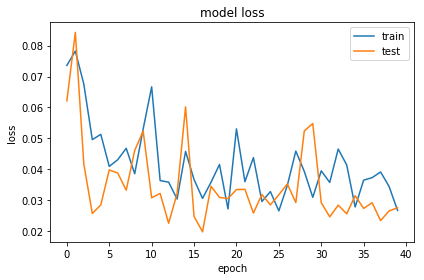

In [14]:
#Plotting the metrics
fig = plt.figure()
#printing training loss and test loss
plt.subplot(1,1,1)
plt.plot(trainingloss)
plt.plot(testlosses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

#### WRITE UP


## 1. Training and testing accuracy vs epoch plots
We see the following training and testing accuracy vs epoch plots:
<br>Encoder
<br>The encoder is made of 2 fully connected layers which are merely reducing the features. From 33 input features we get 20 features adn then 20 to 10 features. This is dimension reduction.
<br>
<br>Decoder
<br>The exact opposite of encoding is done, where 10 features are input to get the initial data of 33 dimensions. This is done to form our own data and then see whether we can form the same data again. This was a form of upsupervised learning as we were not given any labels and are supposed to just recontruct the magnetic fields. With such a simple model, and learing rate of 0.01 and weight decay of 0.5, the reconstruction of data can be performed with train and test losses as 0.0267 and 0.0275 respectively. This is shown by the plot for the same is shown below:
<br>Accuracy Plot and Loss Plot
<br><img src="plot1.png">




## 2. Representative of the weight and biases
Default initial weights: 
[[-0.0671, -0.0430, -0.1428, -0.1419, -0.0509,  0.0101,  0.0184, -0.1388,
   0.0543,  0.0973,  0.0300,  0.1026, -0.0974, -0.0061, -0.0442, -0.0856,
   0.1356, -0.0817, -0.1358, -0.1029, -0.1060, -0.0683,  0.1054,  0.0082,
   0.1312,  0.0308,  0.0811, -0.0261, -0.1023,  0.0353,  0.0608,  0.1198,
   0.1077],
   .....,
   [-0.1407, -0.1045,  0.1671, -0.1641, -0.0263, -0.1001, -0.1513, -0.1152,
    -0.0328,  0.1602, -0.0696,  0.0975, -0.1374,  0.0439,  0.0647, -0.0158,
     0.0169,  0.1483,  0.1582,  0.0425, -0.0044, -0.1055,  0.0456, -0.0488,
     -0.0700, -0.0655, -0.0640, -0.1464,  0.0428,  0.0433, -0.0816, -0.0460,
     -0.0015]]
Default initial biases: 
[ 0.1082, -0.0354,  ...., -0.0748,  0.1025]
<br>The initialization of the weights happens as follows: Weights are initialised within the range [-stdv, stdv] where, stdv = 1. / math.sqrt(self.weight.size(1)) and if the bias is not None, then it is initialised within the same range. 
<br>It is beneficial to use small value for bias and hence, bias = True is included, but its more commonly used to have 0 biases.


## 3. What is used and why
4.1 Initial Shape
<br>The Three Meter dataset consists of 139201 records having 33 features.
<br>This is the dataset having no labels, hence, by using autoencoders, unsupervised learning is to be performed to learn the data and reconstruct the data.
<br>Splitting of training data and test data is done. This splitting is done as 85%-15% for training data and testing data respectively which is the default. 

## 4. About network's shape and layer choices, loss function and activation function
### 4.1 Network's shape
A typical autoencoder consists of multiple convolutional layers that perform dimensionality reduction using encoder and then reforms the data to make the same data using decoder.
The encoder has 2 fully connected layers, which perform reduction from 33 to 20 and then 20 to 10 features. The decoder is exactly the opposite, where 10 to 20 features and then 20 to 33 dimensioned data is formed.
<br>Encoder:
<br>The shape of the input is (118320, 33), that is 118320 records having 33 features each.
<br>The first fully conneted layer will take input equal to number of features that is 33 and reduce it to 20 features. No, activation function is applied. The next and final fully connected layer will transform the 20 features to 10 features. It is observed that activation function makes the larning stagnate and inturn no learning happens.

<br>Decoder:
<br>The first fully conneted layer will take least reduced features that is 10 and convert it to 20 and then next fully connected layer will increase it to actual dimensions, that is 20 to 33.
<br>Here too, no activation function is applied as the encoder and decoder network architectures have to be the same.

<br>This is acted upon by Adam Optimizer.


### 4.2 Layer Choice
<br><br>4.2.1 Fully connected layers
<br>This layer takes all 33 features and reduces it to learn better to form the same data again.
br><br>4.2.2 Adam Optimizer
<br>This is the optimization algorithm used to handle sparse gradients if they occur during training.
<br><br>4.2.4 Learning Rate
<br>Slower learning rate gives smoother increase in accuracy over faster learning rate as can be seen in the plot.
<br><br>4.2.5 Weight decay
<br>The weight decay is performed as a regularization technique to decrease the magnitudes of the weights and prevent overfitting. A 0.5 scale weight decay is performed here.


### 4.3 Loss Function:
L1 Loss is used as the loss function as, it has the quality that leads the weights become sparse during optimization, that is tend to very close to zero. This makes it possible that network having L1 loss ends up with a small subset of their most important inputs and resistant to noise, which would help develop the same data again.


### 4.4 Splitting Dataset
The dataset is supposed to be technically divided into a 67%-33%; training and testing data because it is widely performed and most efficient. But, here, the most common split is used, as 85%-15%.